In [15]:
from tomoSegmentPipeline.utils.common import read_array, write_array
from tomoSegmentPipeline.utils import setup

import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from skimage.util import random_noise
import pyfastnoisesimd as fns
import mrcfile

def standardize(X):
    mean = X.mean()
    std = X.std()
    new_X = (X - mean) / std

    return new_X

def clip(X, low=0.005, high=0.995):
    # works with tensors =)
    return np.clip(X, np.quantile(X, low), np.quantile(X, high))

PARENT_PATH = setup.PARENT_PATH
ISONET_PATH = os.path.join(PARENT_PATH, 'data/isoNet/')

%matplotlib inline
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Make dummy tomograms

In [8]:
# cet_path = os.path.join(PARENT_PATH, 'data/raw_cryo-ET/tomo02.mrc') 
# cet_path = os.path.join(ISONET_PATH, 'RAW_dataset/RAW_allTomos_deconv/tomo04.mrc') 
# out_filename = os.path.join(PARENT_PATH, 'data/S2SDenoising/dummy_tomograms/tomo04_deconvDummy.mrc')
# cet_path = os.path.join(ISONET_PATH, 'RAW_dataset/RAW_allTomos_deconv/tomo02.mrc') 
# out_filename = os.path.join(PARENT_PATH, 'data/S2SDenoising/dummy_tomograms/tomo02_deconvDummy.mrc')
cet_path = os.path.join(PARENT_PATH, 'data/nnUnet/nifti_files/tomo02_bin4_denoised_0000.nii.gz') 
out_filename = os.path.join(PARENT_PATH, 'data/S2SDenoising/dummy_tomograms/tomo02_cryoCAREDummy.mrc')


tomo_data = read_array(cet_path)
tomo_data.shape

(464, 928, 928)

In [9]:
z,y,x = tomo_data.shape

In [10]:
dummy_tomo = tomo_data[z//4:3*z//4, y//4:3*y//4, x//4:3*x//4]
dummy_tomo.shape

(232, 464, 464)

(array([3.6000000e+01, 6.8500000e+02, 2.6340000e+03, 4.8930000e+03,
        4.5754000e+04, 4.9886798e+07, 6.3440000e+03, 1.2710000e+03,
        2.4000000e+02, 1.7000000e+01]),
 array([-62.753998 , -50.964275 , -39.174553 , -27.384829 , -15.595105 ,
         -3.8053818,   7.9843416,  19.774065 ,  31.563787 ,  43.35351  ,
         55.143234 ], dtype=float32),
 <BarContainer object of 10 artists>)

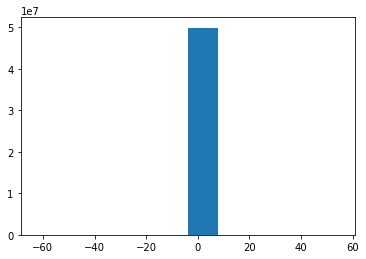

In [11]:
plt.hist(dummy_tomo.flatten())

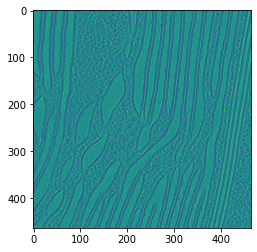

In [12]:
plt.imshow(dummy_tomo[232//2])

In [13]:
write_array(dummy_tomo, out_filename)

# Noisy versions

## Poisson + Gauss

In [34]:
cet_path = os.path.join(PARENT_PATH, 'data/S2SDenoising/dummy_tomograms/tomo02_cryoCAREDummy.mrc')
# cet_path = os.path.join(PARENT_PATH, 'data/S2SDenoising/dummy_tomograms/tomoPhantom_model9.mrc')
tomo_data = read_array(cet_path)
tomo_data = standardize(tomo_data)
m = tomo_data.min()
tomo_data -= m
tomo_shape = np.array(tomo_data.shape)
tomo_shape

array([232, 464, 464])

In [35]:
noisy_tomo = random_noise(tomo_data, mode='poisson', clip=False)
noisy_tomo = random_noise(noisy_tomo, mode='gaussian', var=5, mean=0, clip=False)

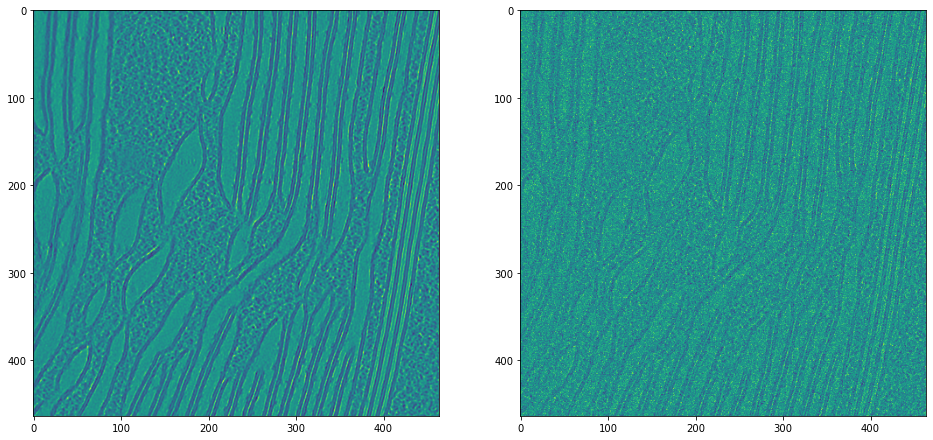

In [36]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 12))
ax0.imshow(tomo_data[tomo_shape[0]//2])
ax1.imshow(noisy_tomo[tomo_shape[0]//2])

(array([3.6000000e+01, 6.8500000e+02, 2.6340000e+03, 4.8930000e+03,
        4.5754000e+04, 4.9886798e+07, 6.3440000e+03, 1.2710000e+03,
        2.4000000e+02, 1.7000000e+01]),
 array([  0.      ,  10.388881,  20.777761,  31.166643,  41.555523,
         51.944405,  62.333286,  72.72217 ,  83.111046,  93.49993 ,
        103.88881 ], dtype=float32),
 <BarContainer object of 10 artists>)

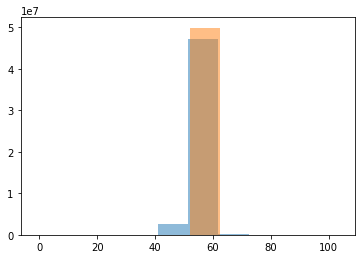

In [37]:
plt.hist(noisy_tomo.flatten(), alpha=0.5)
plt.hist(tomo_data.flatten(), alpha=0.5)

In [39]:
filename = cet_path.replace('.mrc', '_noisyGaussPoiss.mrc')
with mrcfile.new(filename, overwrite=True) as mrc:
    mrc.set_data(np.float32(noisy_tomo))

## Structured Noise

In [2]:
cet_path = os.path.join(PARENT_PATH, 'data/S2SDenoising/dummy_tomograms/tomo02_cryoCAREDummy.mrc')
# cet_path = os.path.join(PARENT_PATH, 'data/S2SDenoising/dummy_tomograms/tomoPhantom_model9.mrc')
tomo_data = read_array(cet_path)
tomo_data = standardize(tomo_data)
m = tomo_data.min()
tomo_data -= m
tomo_shape = np.array(tomo_data.shape)
tomo_shape

array([232, 464, 464])

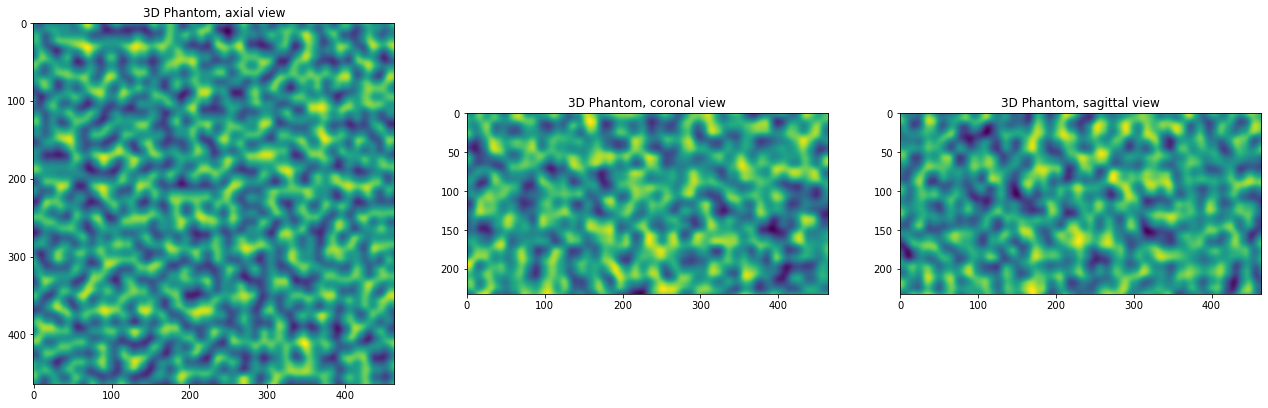

In [18]:
shape = tomo_shape
N_threads = 4

perlin = fns.Noise(seed=0, numWorkers=N_threads)
perlin.frequency = 0.05
perlin.noiseType = fns.NoiseType.Perlin
perlin.fractal.octaves = 4
perlin.fractal.lacunarity = 5
perlin.fractal.gain = 0.45
perlin.perturb.perturbType = fns.PerturbType.NoPerturb
noise = perlin.genAsGrid(shape)
noise = (noise-noise.min())/(noise.max()-noise.min())

zidx, yidx, xidx = tomo_shape//2

plt.figure(figsize=(22, 12)) 
plt.subplot(131)
plt.imshow(noise[zidx,:,:])
plt.title('3D Phantom, axial view')

plt.subplot(132)
plt.imshow(noise[:,yidx,:])
plt.title('3D Phantom, coronal view')

plt.subplot(133)
plt.imshow(noise[:,:,xidx])
plt.title('3D Phantom, sagittal view')
plt.show()

(array([  411198.,  1873283.,  5192171.,  9461516., 12513319., 10398557.,
         6758313.,  2607639.,   664054.,    68622.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

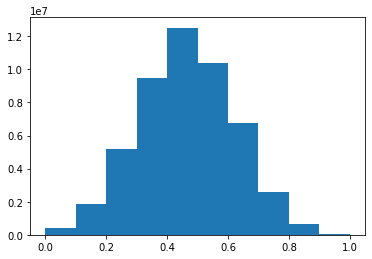

In [4]:
plt.hist(noise.flatten())

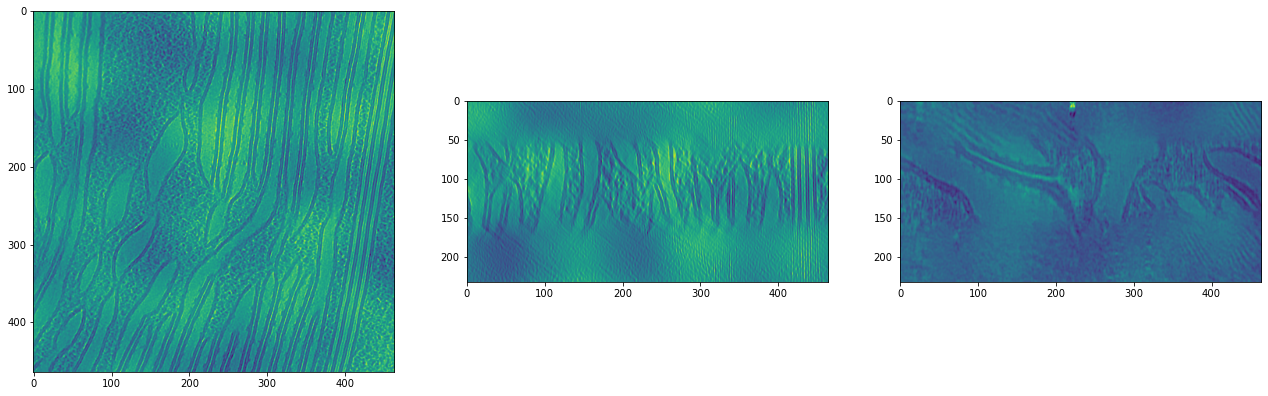

In [10]:
thresh = 0.0
noisy_tomo = np.where(noise<thresh, thresh, noise)
noisy_tomo = tomo_data+5*noisy_tomo

zidx, yidx, xidx = tomo_shape//2

plt.figure(figsize=(22, 12)) 
plt.subplot(131)
plt.imshow(noisy_tomo[zidx,:,:])

plt.subplot(132)
plt.imshow(noisy_tomo[:,yidx,:])


plt.subplot(133)
plt.imshow(noisy_tomo[:,:,xidx])
plt.show()

(array([3.6000000e+01, 6.8500000e+02, 2.6340000e+03, 4.8930000e+03,
        4.5754000e+04, 4.9886798e+07, 6.3440000e+03, 1.2710000e+03,
        2.4000000e+02, 1.7000000e+01]),
 array([  0.      ,  10.388881,  20.777761,  31.166643,  41.555523,
         51.944405,  62.333286,  72.72217 ,  83.111046,  93.49993 ,
        103.88881 ], dtype=float32),
 <BarContainer object of 10 artists>)

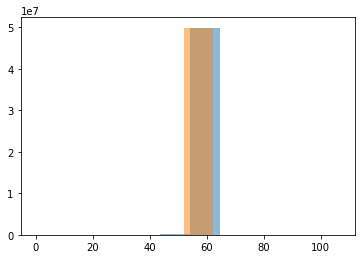

In [11]:
plt.hist(noisy_tomo.flatten(), alpha=0.5)
plt.hist(tomo_data.flatten(), alpha=0.5)

In [12]:
filename = cet_path.replace('.mrc', '_noisyPerlin.mrc')
with mrcfile.new(filename, overwrite=True) as mrc:
    mrc.set_data(np.float32(noisy_tomo))

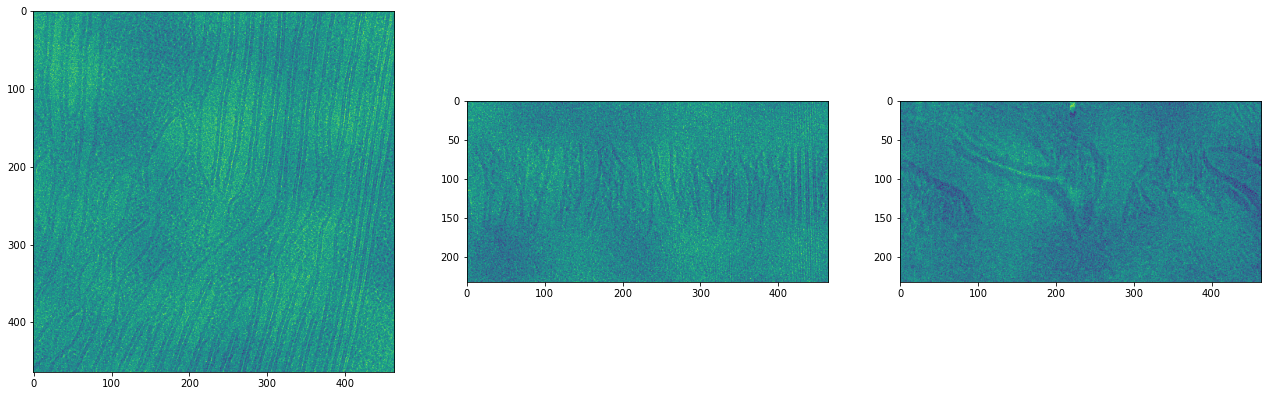

In [13]:
noisier_tomo = random_noise(tomo_data, mode='poisson', clip=False)
noisier_tomo = random_noise(noisier_tomo, mode='gaussian', var=5, mean=0, clip=False)
noisier_tomo = noisier_tomo+5*noise

zidx, yidx, xidx = tomo_shape//2

plt.figure(figsize=(22, 12)) 
plt.subplot(131)
plt.imshow(noisier_tomo[zidx,:,:])

plt.subplot(132)
plt.imshow(noisier_tomo[:,yidx,:])


plt.subplot(133)
plt.imshow(noisier_tomo[:,:,xidx])
plt.show()

In [14]:
filename = cet_path.replace('.mrc', '_noisyGaussPoissPerlin.mrc')
with mrcfile.new(filename, overwrite=True) as mrc:
    mrc.set_data(np.float32(noisier_tomo))